In [15]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
import pandas as pd

from pathlib import Path
from dateutil import parser

from eofs.standard import Eof
from scipy.ndimage import uniform_filter

%matplotlib inline

In [2]:
x_velpaths = list(Path('Vels_Tim').glob('*vx_v*')) # Enter your path to the Vels_Tim folder
x_err_velpaths = list(Path('Vels_Tim').glob('*ex_v*'))

vel_startdates = [parser.parse(str(x_velpaths[i])[21:28]) for i in range(len(x_velpaths))] 
vel_enddates = [parser.parse(str(x_velpaths[i])[29:36]) for i in range(len(x_velpaths))]

vel_middates = [vel_startdates[i] + (vel_enddates[i] - vel_startdates[i]) / 2 for i in range(len(x_velpaths))] # When I do the daily vel interpolations, I use the mid-date
                                                                                                               # of the velmap as the sampled velocity date
    
x_vels = [rio.open(x_velpaths[i]).read(1) for i in range(len(x_velpaths))] # Numpy arrays for all velocity maps
x_err_vels = [rio.open(x_err_velpaths[i]).read(1) for i in range(len(x_velpaths))]

# [print(rio.open(x_velpaths[i]).meta['transform']) for i in range(len(x_velpaths))]

In [ ]:
i = -6#-5
print(x_velpaths[i])
x_vels_single = rio.open(x_velpaths[i]).read(1) # Numpy arrays for all velocity maps
x_vels_single[x_vels_single<-1e7] = np.nan
plt.imshow(x_vels_single, vmin=-5000, vmax=1000)

In [50]:
# Don't know if a Dataframe is necessary, but I put the dates and arrays in here, then sorted by date
# Calling the entire dataframe is fairly slow, probably because all the large arrays
vel_df = pd.DataFrame({'Start Date' : vel_startdates, 'End Date' : vel_enddates, 'mid_date' : vel_middates, 'x_vels' : x_vels, 'x_vel_errs' : x_err_vels})

vel_df.sort_values('Start Date', inplace = True) # Data is not initially read in in-order.
    # This sort sorts the entire dataframe
vel_df.reset_index(drop = True, inplace = True)

vel_df.head()

,Start Date,End Date,mid_date,x_vels,x_vel_errs
0,2019-06-06,2019-06-17,2019-06-11 12:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1..."
1,2019-06-17,2019-06-28,2019-06-22 12:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1..."
2,2019-06-28,2019-07-09,2019-07-03 12:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1..."
3,2019-07-09,2019-07-31,2019-07-20 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1..."
4,2019-07-31,2019-08-11,2019-08-05 12:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1..."


In [51]:
# Define the nan values for the velocity fields
for i in range(len(vel_df)):
    vel_df.iloc[i].x_vels[ vel_df.iloc[i].x_vels<-1e7 ] = np.nan # Define the nan values

print(vel_df.iloc[1])

Start Date                                  2019-06-17 00:00:00
End Date                                    2019-06-28 00:00:00
mid_date                                    2019-06-22 12:00:00
x_vels        [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
x_vel_errs    [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
Name: 1, dtype: object


In [ ]:
# Plot the velocity fields
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
for i in range(len(vel_df)):
    col = i %  ax.shape[1]
    row = i // ax.shape[1]
    img = ax[row, col].imshow(vel_df.iloc[i].x_vels, vmin=-5000, vmax=1000)
    ax[row, col].set_title(vel_df.iloc[i].mid_date)
    #plt.colorbar(img, ax=ax[row, col])

## Create data volume

In [52]:
# data_vol = np.array(x_vels).reshape( (652,546, 31))

data_vol = np.zeros( (len(vel_df),
                      vel_df.iloc[0].x_vels.shape[0], 
                      vel_df.iloc[0].x_vels.shape[1],
                    ) )
for i in range(len(vel_df)):
    data_vol[i, :,:] = vel_df.iloc[i].x_vels

# median_vel = np.nanmedian(data_vol, 0)
mean_vel = np.nanmean(data_vol, 0)

anom_vol = np.array(x_vels) - mean_vel[np.newaxis] # Make a datavolume of velocity anomalies with the mean
# anom_vol = np.log(np.array(x_vels)) - np.log(mean_vel[np.newaxis]) # Make a datavolume of velocity anomalies with the mean

/var/folders/x4/_qy1pvxd5lg_685vzy608d200000gn/T/ipykernel_64574/764998801.py:11: RuntimeWarning: Mean of empty slice
  mean_vel = np.nanmean(data_vol, 0)


Text(0.5, 1.0, 'Mean velocity')

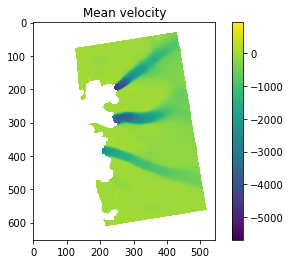

In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(mean_vel)
plt.colorbar(img)
ax.set_title('Mean velocity')
# plt.savefig('velocity median.png')

Text(0, 0.5, 'Velocity anomaly (m/yr) \n (Positive is faster than mean)')

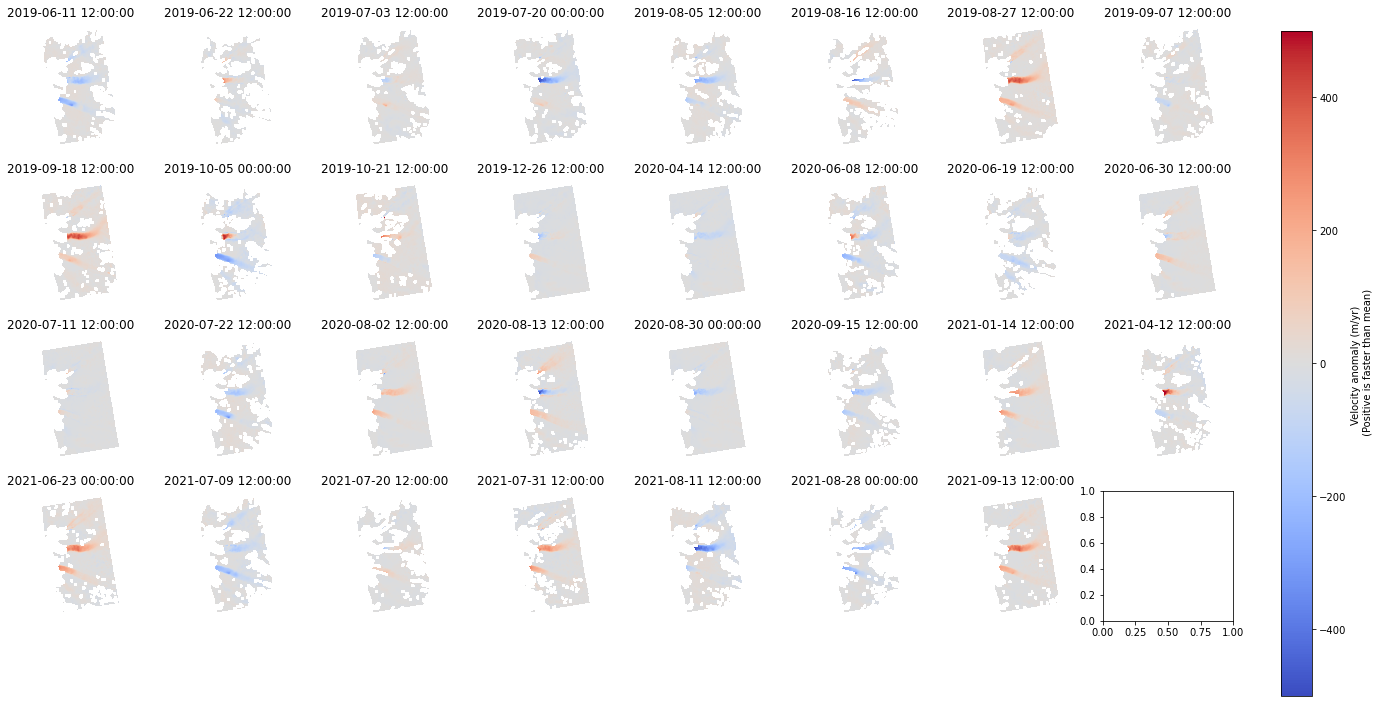

In [28]:
# # fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
for i in range(len(vel_df)):
    col = i %  ax.shape[1]
    row = i // ax.shape[1]
    # img = ax[row, col].imshow(vel_df.iloc[i].x_vels - mean_vel, 
    img = ax[row, col].imshow(anom_vol[i,:,:], 
                              cmap='coolwarm', vmin=-500, vmax=500)
    # img = ax[row, col].imshow(np.log(anom_vol[i,:,:]), 
    #                           cmap='coolwarm')#, vmin=-500, vmax=500)
    ax[row, col].set_title(vel_df.iloc[i].mid_date)
    ax[row, col].axis('off')
cax = plt.axes([.93, .03, .02, .84])
plt.colorbar(img, cax=cax)#ax[row, col])
cax.set_ylabel('Velocity anomaly (m/yr) \n (Positive is faster than mean)')
# plt.savefig('vel_anomaly2.png')

In [53]:
# Initialize variable "anom_vol_fill," that starts with anom_vol (including known anomalies), 
#   but assumes as a first guess that the anomaly is zero where it is unmeasured
anom_vol_fill = anom_vol.copy()
anom_vol_fill[np.isnan(anom_vol)] = 0

#Don't operate on values where nothing is known, outside of the MEASURES rectangle
outside_bounds = np.isnan(mean_vel[np.newaxis])
anom_vol_fill[np.tile(outside_bounds, (len(vel_df), 1,1))] = np.nan



### Instructions/exploring eofs
Following https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html

Also, see this very helpful page: https://ajdawson.github.io/eofs/latest/api/eofs.standard.html#eofs.standard.Eof

In [9]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.

# eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)


In [10]:
eof1 = solver.eofs(neofs=5, eofscaling=0)


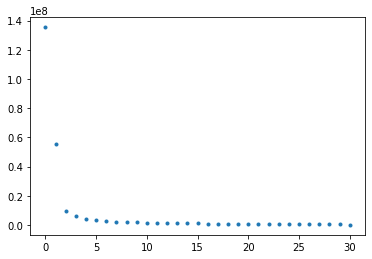

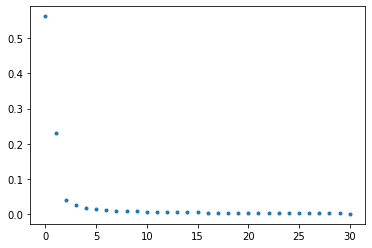

In [11]:
plt.plot(solver.eigenvalues(), '.')
plt.figure()
plt.plot(solver.varianceFraction(), '.')

In [12]:
eof1.shape

(5, 652, 546)

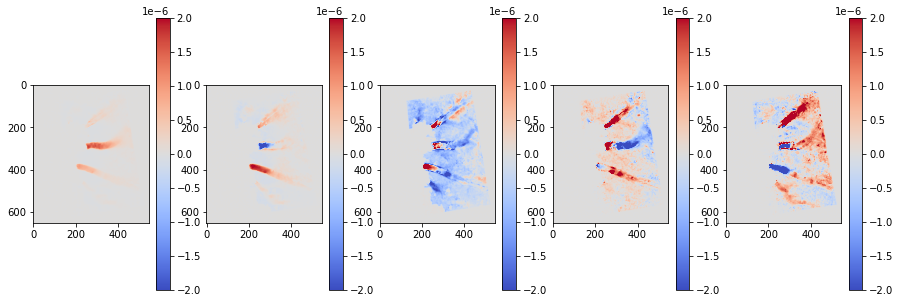

In [13]:
# eof1 = solver.eofsAsCorrelation(neofs=5)
eof1 = solver.eofs(neofs=5, eofscaling=1)

fig, ax = plt.subplots(ncols=eof1.shape[0], 
                       figsize=(15,5) )
for i in range(eof1.shape[0]):
    img = ax[i].imshow(eof1[i].squeeze(), 
                       # cmap='coolwarm')#, vmin=-200, vmax=200)
                       # cmap='coolwarm', vmin=-0.03, vmax=0.03)
                       cmap='coolwarm', vmin=-2e-6, vmax=2e-6)
    plt.colorbar(img, ax=ax[i])

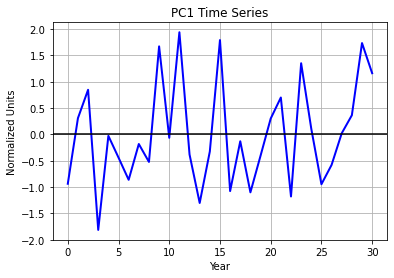

In [14]:

# # Plot the leading EOF expressed as correlation in the Pacific domain.
# clevs = np.linspace(-1, 1, 11)
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
# fill = ax.contourf(lons, lats, eof1.squeeze(), clevs,
#                    transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
# ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
# cb = plt.colorbar(fill, orientation='horizontal')
# cb.set_label('correlation coefficient', fontsize=12)
# plt.title('EOF1 expressed as correlation', fontsize=16)

# Plot the leading PC time series.
fig, ax = plt.subplots()
# years = range(1962, 2012)
# plt.plot(years, pc1, color='b', linewidth=2)
ax.plot(pc1[:,0], color='b', linewidth=2)
ax.axhline(0, color='k')
ax.set_title('PC1 Time Series')
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.grid()
# plt.xlim(1962, 2012)
# plt.ylim(-3, 3)

plt.show()


### Reconstruct fields

In [54]:
# solver = Eof(anom_vol, center=True)

# Run the EOF analysis of the zero-filled anomalies
solver = Eof(anom_vol_fill, center=True)

n_eofs_to_use = 4 # Number of "trusted" EOFs to use to fill values
reconstruction = solver.reconstructedField(n_eofs_to_use)

delta_field = reconstruction - anom_vol_fill # How different is the reconstructed field from the zero-filled field?

i = 14 # Which measures velocity geotiff to look at, for testing/plotting


In [ ]:
reconstruction.shape

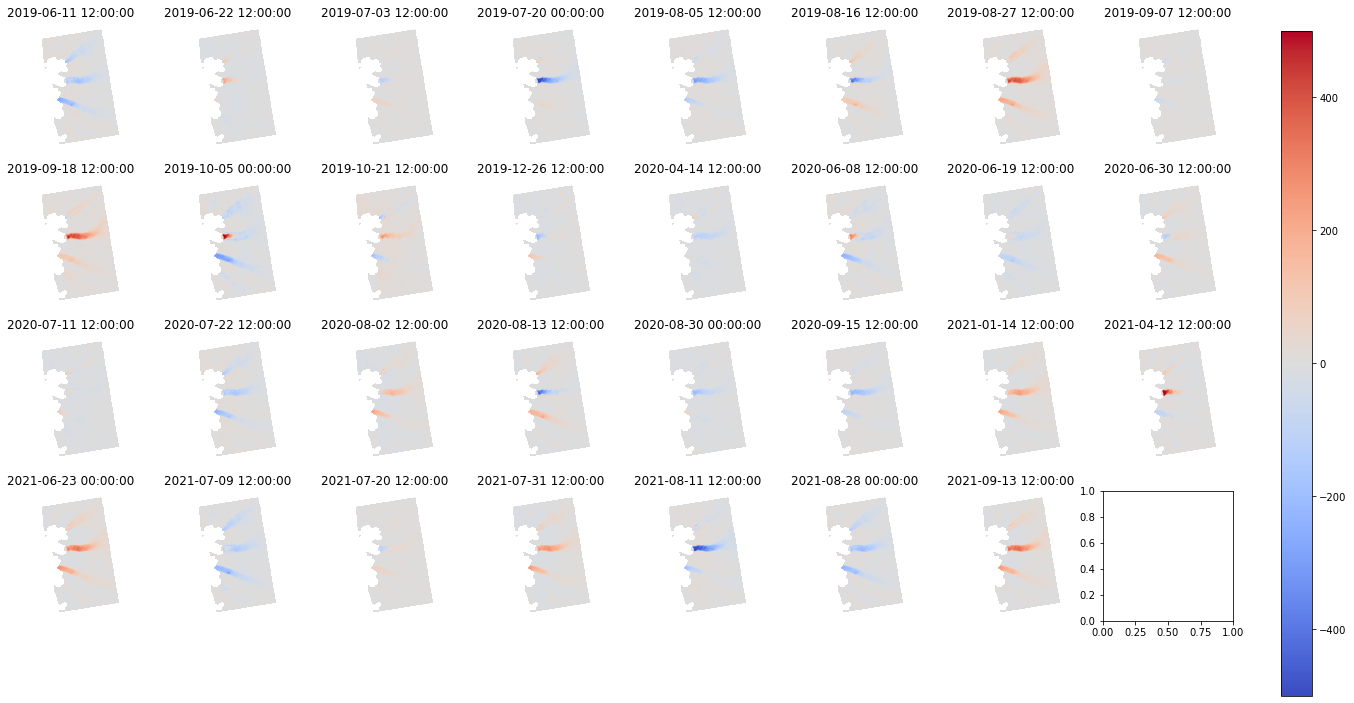

In [55]:
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
for i in range(len(vel_df)):
    col = i %  ax.shape[1]
    row = i // ax.shape[1]
    img = ax[row, col].imshow(reconstruction[i,:,:], 
                              cmap='coolwarm', vmin=-500, vmax=500)
    ax[row, col].set_title(vel_df.iloc[i].mid_date)
    ax[row, col].axis('off')
cax = plt.axes([.93, .03, .02, .84])
plt.colorbar(img, cax=cax)#ax[row, col])
# plt.savefig('vel_anomaly_reconstruct.png')

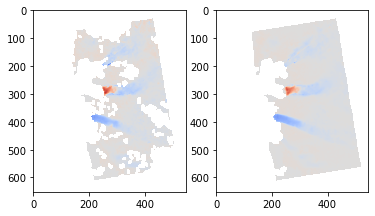

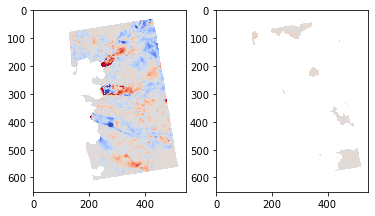

In [11]:

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(anom_vol[i,:,:], 
             cmap='coolwarm', vmin=-400, vmax=400)
ax[1].imshow(reconstruction[i,:,:], 
             cmap='coolwarm', vmin=-400, vmax=400)

delta_field_i = delta_field[i,:,:]

fig, ax = plt.subplots(ncols=2)
# ax[0].imshow(anom_vol[i,:,:], 
#              cmap='coolwarm', vmin=-400, vmax=400)
ax[0].imshow(delta_field[i,:,:], 
             cmap='coolwarm', vmin=-50, vmax=50)
ax[1].imshow(np.ma.masked_array(delta_field_i, ~np.isnan(anom_vol[i,:,:])), 
             cmap='coolwarm', vmin=-50, vmax=50)

#### Key cell: converge on in-filled velocity anomalies, using EOFs

1 320.16900125463224
    4.597316237358196 186.28628453819474
2 320.16900125463224
    4.597316237358196 186.28628453819474
3 186.2521214428209
    2.1575257865627195 66.04077549123522
4 155.1151751808859
    1.3791490846057455 52.6883337374565
5 139.6206684648655
    0.9911387359999363 45.81632827623761
6 124.94085594161129
    0.7650527564232255 39.589306294611646
7 111.8074299275919
    0.6215774467581627 34.175883645694626
8 100.10311854520046
    0.5204197586009586 29.563931564039535
9 89.67169300824935
    0.44711920780942405 25.664739611435834
10 80.3965688762903
    0.3917799108261237 22.406431354218398
11 72.17871916573631
    0.34917177286554574 20.269261366736316
12 64.92110971426018
    0.31481683103613917 18.40060634447201
13 58.525623796771015
    0.28721528047318823 16.744342617332563
14 52.895530280725325
    0.2648756536610779 15.261348480187564
15 47.93885790192644
    0.24604037009852645 13.923736232087265
16 43.57087963591903
    0.23008152509821658 12.7110040161617

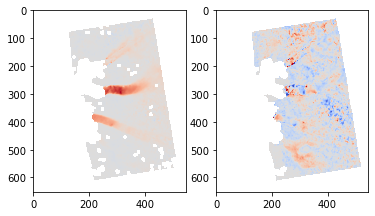

In [56]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(anom_vol[i,:,:], 
             cmap='coolwarm', vmin=-400, vmax=400)
ax[1].imshow(delta_field[i,:,:], 
             cmap='coolwarm', vmin=-50, vmax=50)

# fig, ax = plt.subplots(ncols=2)
# # ax[0].imshow(anom_vol[i,:,:], 
# #              cmap='coolwarm', vmin=-400, vmax=400)
# # ax[0].imshow(delta_field[i,:,:], 
# #              cmap='coolwarm', vmin=-50, vmax=50)
# ax[0].imshow(np.ma.masked_array(reconstruction[i,:,:], ~np.isnan(anom_vol[i,:,:])), 
#              cmap='coolwarm', vmin=-5, vmax=5)
# ax[1].imshow(np.ma.masked_array(delta_field_i, ~np.isnan(anom_vol[i,:,:])), 
#              cmap='coolwarm', vmin=-5, vmax=5)

# Do this while loop until the solution is "sufficiently" good
counter=0
while np.nanmax(delta_field[np.isnan(anom_vol)]) > 5:
    counter+=1; print(counter, np.nanmax(delta_field[np.isnan(anom_vol)]))
    delta_field_i = delta_field[i,:,:] # track one image's delta
    print( '   ', np.nanmean(np.abs( delta_field_i[np.isnan(anom_vol[i,:,:])] )) ,
          np.nanmax( delta_field_i[np.isnan(anom_vol[i,:,:])] ) )
    # delta_field = reconstruction[i,:,:] - anom_vol_fill[i,:,:]
    delta_field = reconstruction - anom_vol_fill

    # ------------------
    # This trio of lines is really the crux, that is iterated over:
        # Use the reconstruction to update the infilled anomalies
        # Calculate the new EOFs with infilled anomalies
        # Create a new reconstruction based on the new EOFs
    anom_vol_fill[np.isnan(anom_vol)] = reconstruction[np.isnan(anom_vol)]
    solver = Eof(anom_vol_fill, center=False)
    reconstruction = solver.reconstructedField(n_eofs_to_use)
    # ------------------
    
    # fig, ax = plt.subplots(ncols=2)
    # ax[0].imshow(anom_vol[i,:,:], 
    #              cmap='coolwarm', vmin=-400, vmax=400)
    # ax[1].imshow(reconstruction[i,:,:], 
    #              cmap='coolwarm', vmin=-400, vmax=400)

    # fig, ax = plt.subplots(ncols=2)
    # ax[0].imshow(anom_vol[i,:,:], 
    #              cmap='coolwarm', vmin=-400, vmax=400)
    # ax[1].imshow(delta_field[i,:,:], 
    #              cmap='coolwarm', vmin=-50, vmax=50)
    
    # fig, ax = plt.subplots(ncols=2)
    # # ax[0].imshow(anom_vol[i,:,:], 
    # #              cmap='coolwarm', vmin=-400, vmax=400)
    # # ax[0].imshow(delta_field[i,:,:], 
    # #              cmap='coolwarm', vmin=-50, vmax=50)
    # ax[0].imshow(np.ma.masked_array(reconstruction[i,:,:], ~np.isnan(anom_vol[i,:,:])), 
    #              cmap='coolwarm', vmin=-5, vmax=5)
    # ax[1].imshow(np.ma.masked_array(delta_field_i, ~np.isnan(anom_vol[i,:,:])), 
    #              cmap='coolwarm', vmin=-5, vmax=5)

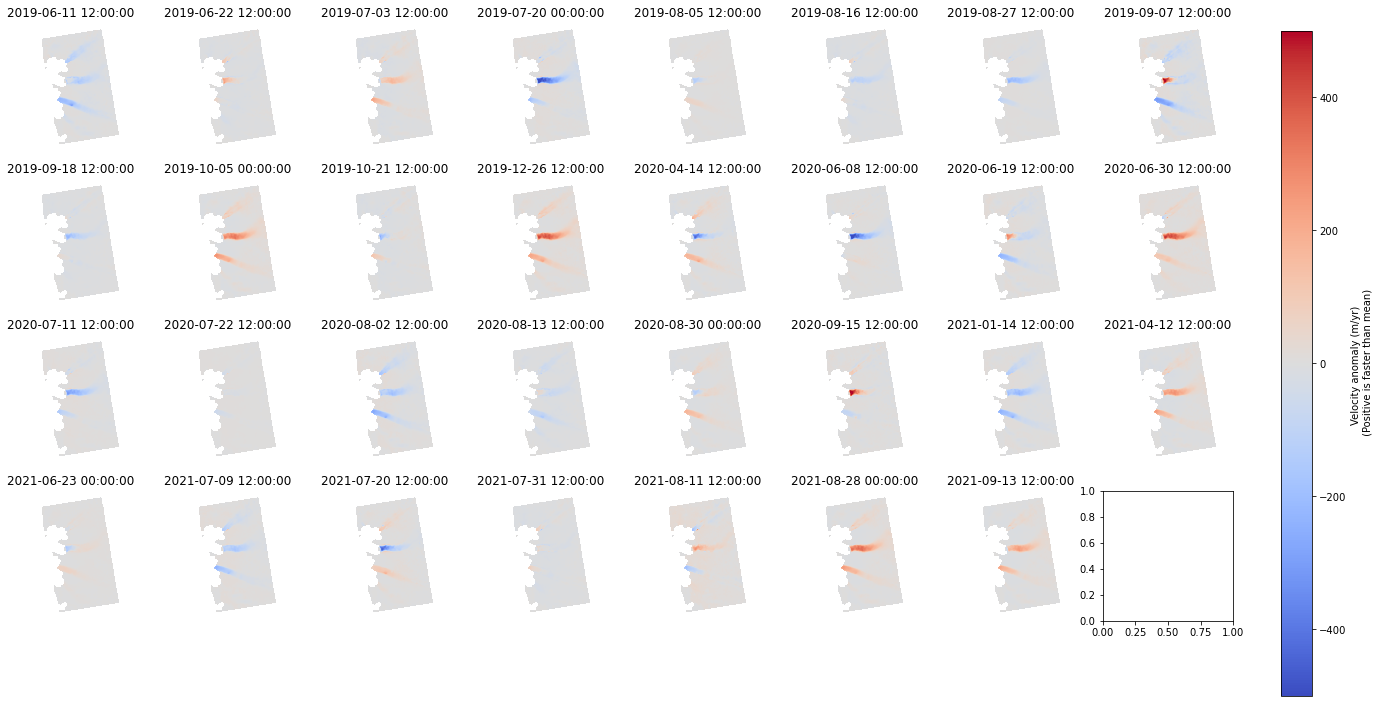

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
for i in range(len(vel_df)):
    col = i %  ax.shape[1]
    row = i // ax.shape[1]
    img = ax[row, col].imshow(reconstruction[i,:,:], 
                              cmap='coolwarm', vmin=-500, vmax=500)
    ax[row, col].set_title(vel_df.iloc[i].mid_date)
    ax[row, col].axis('off')
cax = plt.axes([.93, .03, .02, .84])
plt.colorbar(img, cax=cax)#ax[row, col])
cax.set_ylabel('Velocity anomaly (m/yr) \n (Positive is faster than mean)')
# plt.savefig('vel_reconstructed.png')

Text(0, 0.5, 'Velocity anomaly (m/yr) \n (Positive is faster than mean)')

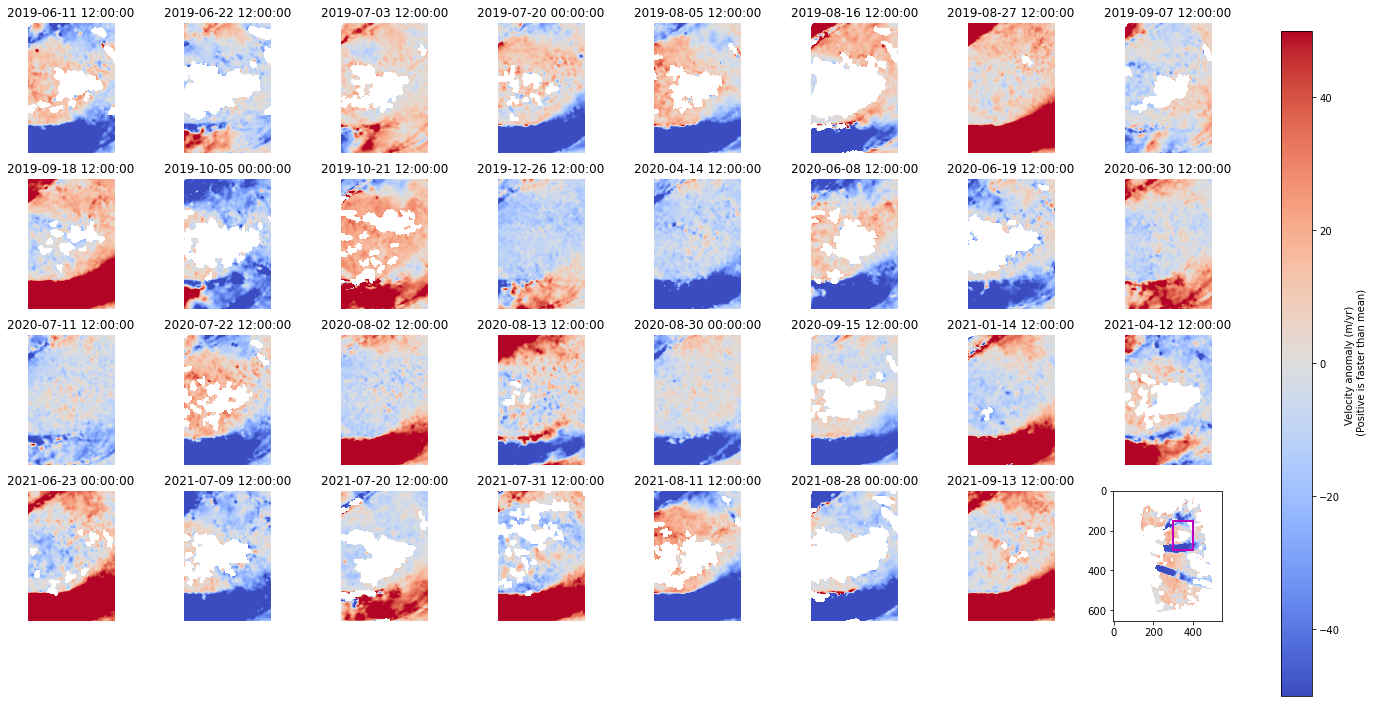

In [62]:
roi = np.array([150, 300, 300, 400]) # [y_top, y_bottom, x_left, x_right]
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
for i in range(len(vel_df)):
    col = i %  ax.shape[1]
    row = i // ax.shape[1]
    img = ax[row, col].imshow(anom_vol[i,roi[0]:roi[1],roi[2]:roi[3]], 
    # img = ax[row, col].imshow(anom_vol_fill[i,roi[0]:roi[1],roi[2]:roi[3]], 
                              cmap='coolwarm', vmin=-50, vmax=50)
    ax[row, col].set_title(vel_df.iloc[i].mid_date)
    ax[row, col].axis('off')

img = ax[3, 7].imshow(anom_vol[0,:,:], 
                          cmap='coolwarm', vmin=-50, vmax=50)

from matplotlib.patches import Rectangle
rect = Rectangle((roi[2], roi[0]), roi[3]-roi[2], roi[1]-roi[0], 
                 linewidth=2,facecolor='none', edgecolor='m')
ax[3,7].add_patch(rect)
# ax[3, 7].axis('off')
cax = plt.axes([.93, .03, .02, .84])
plt.colorbar(img, cax=cax)#ax[row, col])
cax.set_ylabel('Velocity anomaly (m/yr) \n (Positive is faster than mean)')
# plt.savefig('vel_zoom_orig.png')

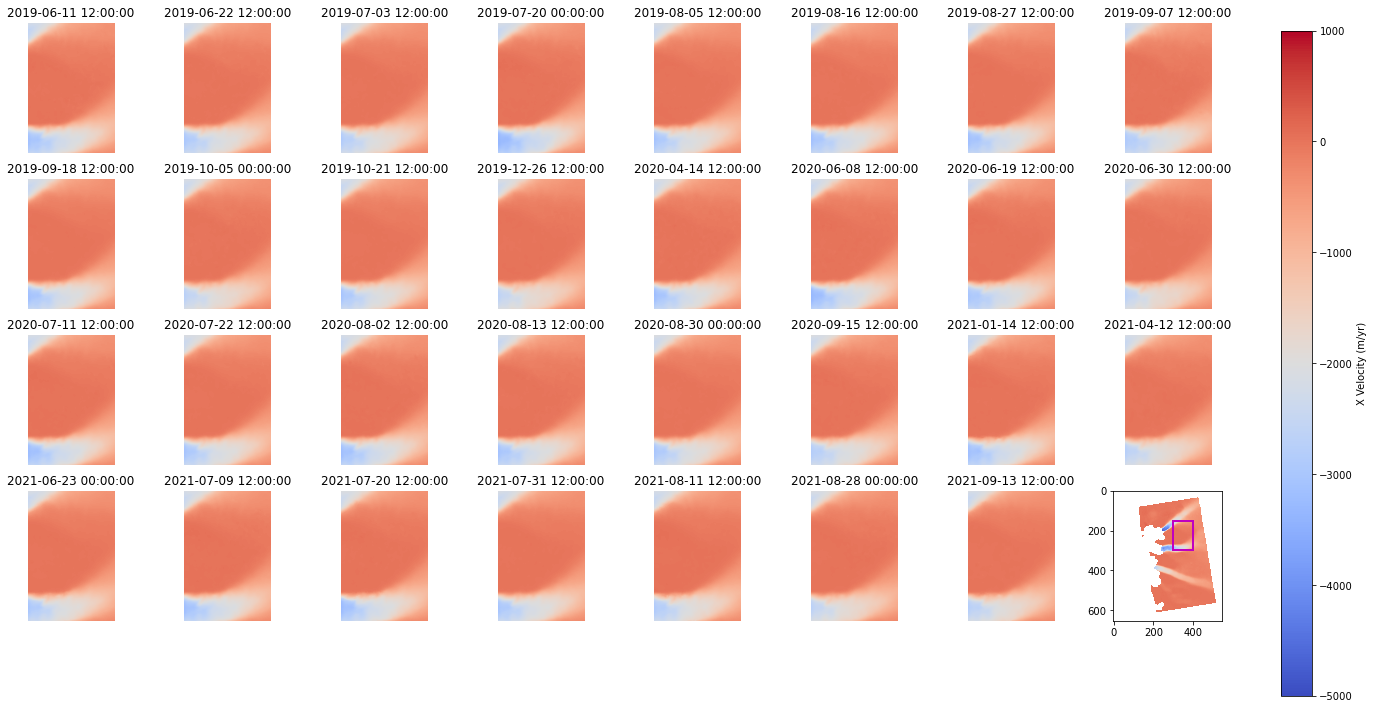

In [13]:
vel_filled
roi = np.array([150, 300, 300, 400]) # [y_top, y_bottom, x_left, x_right]
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
for i in range(len(vel_df)):
    col = i %  ax.shape[1]
    row = i // ax.shape[1]
    # img = ax[row, col].imshow(vel_filled[i,roi[0]:roi[1],roi[2]:roi[3]], 
                              # cmap='coolwarm', vmin=-5000, vmax=1000)
    img = ax[row, col].imshow(anom_vol_fill[i,roi[0]:roi[1],roi[2]:roi[3]], 
                              cmap='coolwarm', vmin=-50, vmax=50)
    ax[row, col].set_title(vel_df.iloc[i].mid_date)
    ax[row, col].axis('off')

img = ax[3, 7].imshow(vel_filled[0,:,:], 
                          cmap='coolwarm', vmin=-5000, vmax=1000)

from matplotlib.patches import Rectangle
rect = Rectangle((roi[2], roi[0]), roi[3]-roi[2], roi[1]-roi[0], 
                 linewidth=2,facecolor='none', edgecolor='m')
ax[3,7].add_patch(rect)
# ax[3, 7].axis('off')
cax = plt.axes([.93, .03, .02, .84])
plt.colorbar(img, cax=cax)#ax[row, col])
cax.set_ylabel('X Velocity (m/yr)')
# plt.savefig('x_vel_filled.png')

### Smooth fields
filled, complete fields come in as `anom_vol_fill`, but reconstructed fields come in as `reconstruction`

In [57]:
vel_filled = mean_vel + anom_vol_fill#reconstruction

In [71]:
smoothing_window = 2000 # m.  Data originally sampled at 100 m

smoothing_factor = smoothing_window // 100

vel_fill_nonan = vel_filled.copy()
vel_fill_nonan[np.isnan(anom_vol_fill)] = 0
smoothed_vels = uniform_filter(vel_fill_nonan, (1,smoothing_factor,smoothing_factor), mode='nearest')
smoothed_anom = smoothed_vels - np.mean(smoothed_vels,0) # mean_vel

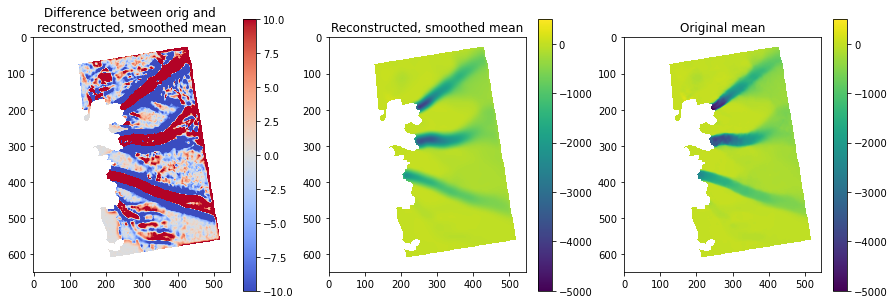

In [72]:
# Plotting
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
img = ax[0].imshow(np.mean(smoothed_vels,0) - mean_vel, 
                   cmap='coolwarm', vmin=-10, vmax=10)
ax[0].set_title('Difference between orig and \nreconstructed, smoothed mean')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(np.ma.masked_array(np.mean(smoothed_vels,0),np.isnan(mean_vel)),
                   vmin=-5000, vmax=500)
ax[1].set_title('Reconstructed, smoothed mean')
fig.colorbar(img, ax=ax[1])
img = ax[2].imshow(mean_vel, vmin=-5000, vmax=500)
ax[2].set_title('Original mean')
fig.colorbar(img, ax=ax[2])

Text(0, 0.5, 'Velocity anomaly (m/yr) \n (Positive is faster than mean)')

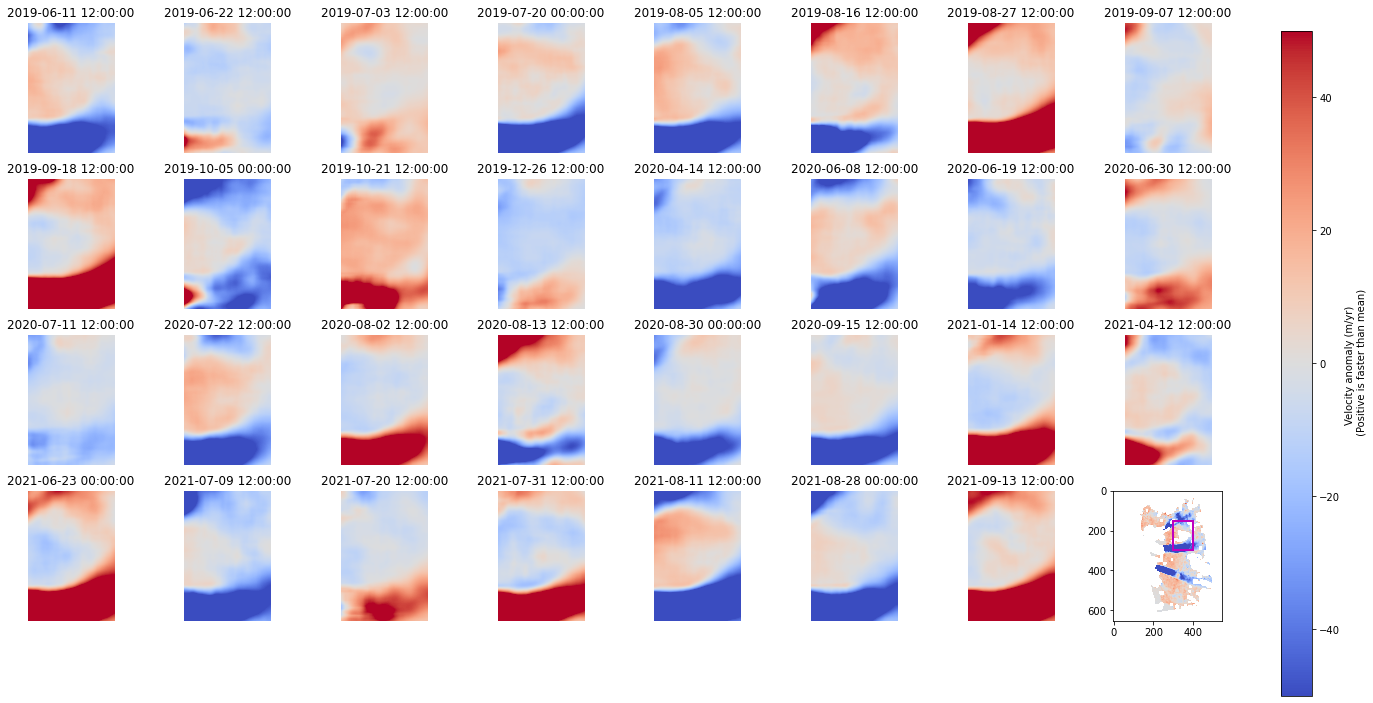

In [73]:
roi = np.array([150, 300, 300, 400]) # [y_top, y_bottom, x_left, x_right]
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(22,11))
for i in range(len(vel_df)):
    col = i %  ax.shape[1]
    row = i // ax.shape[1]
    # img = ax[row, col].imshow(uniform_filter(anom_vol_fill[i,roi[0]:roi[1],roi[2]:roi[3]],
    #                                          11, mode='nearest'), 
    img = ax[row, col].imshow(smoothed_anom[i,roi[0]:roi[1],roi[2]:roi[3]],
                              cmap='coolwarm', vmin=-50, vmax=50)
    ax[row, col].set_title(vel_df.iloc[i].mid_date)
    ax[row, col].axis('off')

img = ax[3, 7].imshow(anom_vol[0,:,:], 
                          cmap='coolwarm', vmin=-50, vmax=50)

from matplotlib.patches import Rectangle
rect = Rectangle((roi[2], roi[0]), roi[3]-roi[2], roi[1]-roi[0], 
                 linewidth=2,facecolor='none', edgecolor='m')
ax[3,7].add_patch(rect)
# ax[3, 7].axis('off')
cax = plt.axes([.93, .03, .02, .84])
plt.colorbar(img, cax=cax)#ax[row, col])
cax.set_ylabel('Velocity anomaly (m/yr) \n (Positive is faster than mean)')
# plt.savefig('vel_zoom_filled_smooth2.png')

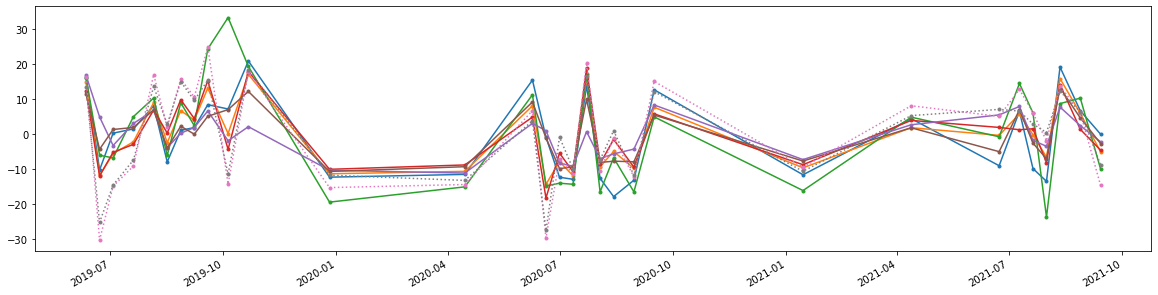

In [74]:
poi = np.array([160, 350]) # [y, x]
poi = np.array([350, 400]) # [y, x]
poi = np.array([500, 300]) # [y, x]
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(vel_df.mid_date.to_numpy(), 
        anom_vol_fill[:, poi[0], poi[1]],
        '.-')
ax.plot(vel_df.mid_date.to_numpy(), 
        smoothed_anom[:, poi[0], poi[1]],
        '.-')
fig.autofmt_xdate()

# fig, ax = plt.subplots()
ax.plot(vel_df.mid_date.to_numpy(), 
        anom_vol_fill[:, poi[0]+10, poi[1]],
        '.-')
ax.plot(vel_df.mid_date.to_numpy(), 
        smoothed_anom[:, poi[0]+10, poi[1]],
        '.-')
# fig.autofmt_xdate()

# fig, ax = plt.subplots()
ax.plot(vel_df.mid_date.to_numpy(), 
        anom_vol_fill[:, poi[0], poi[1]+10],
        '.-')
ax.plot(vel_df.mid_date.to_numpy(), 
        smoothed_anom[:, poi[0], poi[1]+10],
        '.-')

# fig, ax = plt.subplots()
ax.plot(vel_df.mid_date.to_numpy(), 
        anom_vol_fill[:, poi[0]-20, poi[1]-10],
        '.:')
ax.plot(vel_df.mid_date.to_numpy(), 
        smoothed_anom[:, poi[0]-20, poi[1]-10],
        '.:')

fig.autofmt_xdate()